<a href="https://colab.research.google.com/github/akshaygrao77/Deep-learning-assignment1/blob/Question-3/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import math
from decimal import *
# Only used to show progressbar while inside an epoch
from tqdm.notebook import tqdm 

In [100]:
# !pip install wandb
# !wandb login

In [101]:
# import wandb

# wandb.init(project="Deep learning assignment1", entity="akshaygrao")

In [102]:
# wandb.config = {
#   "learning_rate": 0.001,
#   "epochs": 100,
#   "batch_size": 128
# }

# **Question 1 starts**

Loading dataset from fashio-mnist

In [103]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [104]:
def print_image_per_class():
  num_class=10
  for cls in range(num_class):
    i=0
    while(True):
      i=i+1
      if(y_train[i] == cls):
        # image = x_train[i]
        plt.imshow( x_train[i], cmap='gray')
        plt.show()
        plt.close()
        break;

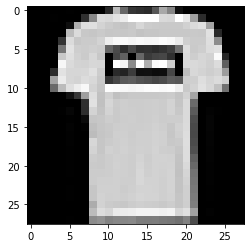

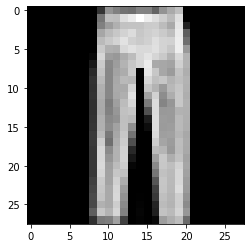

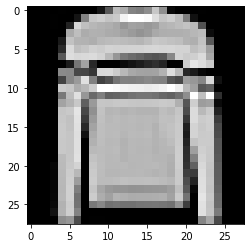

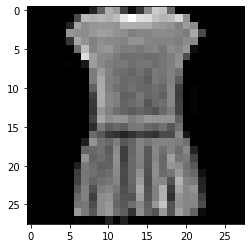

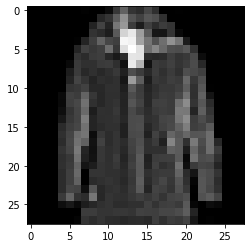

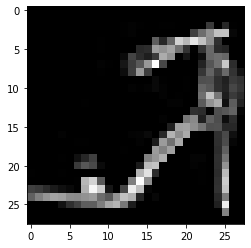

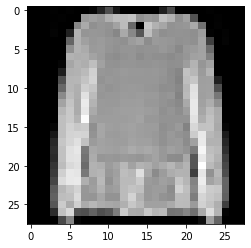

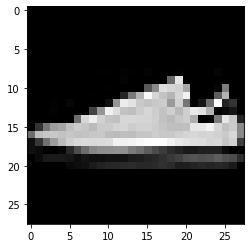

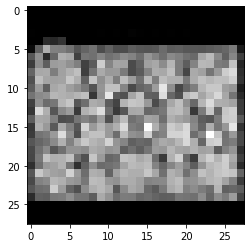

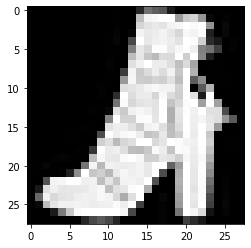

In [105]:
print_image_per_class()

# **Question 2 starts**

In [106]:
x_train.shape

(60000, 28, 28)

In [107]:
x_test.shape

(10000, 28, 28)

Flatten each image into a 1-d array to input to the network

In [108]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

Normalise the array to [0,1] interval

In [127]:
# x_train = x_train + 1
# x_test = x_test + 1
x_train = x_train / 255
x_test = x_test / 255

In [110]:
x_train.shape

(60000, 784)

In [111]:
x_test.shape

(10000, 784)

Categorical encoding for labels

In [112]:
import tensorflow.keras as keras
num_categories = 10

y_train = keras.utils.to_categorical(y_train, num_categories)
y_test = keras.utils.to_categorical(y_test, num_categories)

In [113]:
y_train.shape

(60000, 10)

In [114]:
y_test.shape

(10000, 10)

In [115]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [116]:
Activation().computeReluGrad(np.array([100,-5]))

array([1., 0.])

In [117]:
class Activation:
    def computeSoftmaxGrad(self,H):
      grad_softmax_jacobian = np.zeros(H.shape[0]*H.shape[0]).reshape(H.shape[0],H.shape[0])
      for i in range(H.shape[0]):
        for j in range(H.shape[0]):
          if(i == j):
            grad_softmax_jacobian[i][j] = H[i]*(1-H[j])
          else:
            grad_softmax_jacobian[i][j] = -H[i]*H[j]
      return grad_softmax_jacobian
  
    def computeSigmoidGrad(self,H):
      # print("Grad Sigmoid ",H)
      # print("number of non-zeros in H:",np.count_nonzero(H))
      ret = H*(1-H)
      # print("Ret ",ret)
      # print("number of non-zeros in ret:",np.count_nonzero(ret))
      return ret 

    def computeTanhGrad(self,H):
      ret = 1 - H**2
      if(~(np.isfinite(ret).all())):
        if(np.isnan(ret).any()):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("Gradient Tanh ret",ret)
        ret = replaceNanWithMaxAndMin(ret)
      return ret 
    
    def computeReluGrad(self,A):
       return 1.0 * (A > 0)

    def sigmoid(self, X):
      # print("Sigmoid",X)
      exp = np.exp(-X)
      # print("Exp:",exp)
      if(~(np.isfinite(exp).all())):
        if(np.isnan(exp).any()):
          print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
          print("Sigmoid X",X)
          print("Sigmoid exp before",exp)
        exp = replaceNanWithMaxAndMin(exp)
      
      ret = 1.0 / (1.0 + exp)
      # print("Ret sigmoid:",ret)
      return ret

    def relu(self,X):
      ret = np.maximum(0.0,X)
      return ret
    
    def tanh(self,X):
      ret = np.tanh(X)
      if(~(np.isfinite(ret).all())):
        if(np.isnan(ret).any()):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("Tanh ret",ret)
        ret = replaceNanWithMaxAndMin(ret)
      return ret

    def softmax(self, X):
      Z = X-max(X)
      exps = np.exp(Z)
      if(~(np.isfinite(exps).all())):
        if(np.isnan(exps).any()):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("softmax X",X)
          print("softmax exps",exps)
        exps = replaceNanWithMaxAndMin(exps)
      
      sum = np.sum(exps)
      if(~(np.isfinite(sum).all())):
        if(np.isnan(sum).any()):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("softmax sum",sum)
        sum = replaceNanWithMaxAndMin(sum)

      ret = exps / sum
      if(~(np.isfinite(ret).all())):
        if(np.isnan(ret).any()):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("softmax exps",exps)
          print("softmax sum",sum)
          print("softmax ret",ret)
        ret = replaceNanWithMaxAndMin(ret)

      if(~(np.isfinite(ret).all())):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("softmax X",X)
          print("softmax np.sum(exps)",np.sum(exps))
          print("softmax exps",exps)
      return ret

In [118]:
  def replaceNanWithMaxAndMin(X):
    if(np.isscalar(X)):
      if(X == float("inf")):
          X = 1e+306
      elif(X == float("-inf")):
          X = 1e-306
      else:
        X = 1e-306
    else:
      if(~(np.isfinite(X).all())):
        nan_indices = np.argwhere(~(np.isfinite(X))).flatten()
        # print("nan_indices",nan_indices)
        for ind in nan_indices:
          # print("Ind",ind)
          # print("X[ind]",X[ind])
          if(X[ind] == float("inf")):
            X[ind] = 1e+306
          elif(X[ind] == float("-inf")):
            X[ind] = 1e-306
          else:
            X[ind] = 1e-306
    return X
      

In [119]:
class InputLayer:
  number_of_inputs=0

  def __init__(self,number_of_inputs) -> None:
      self.number_of_inputs = number_of_inputs

In [120]:
class Layer:
  number_of_neurons=0
  activation = 'sigmoid'
  
  def __init__(self,number_of_neurons,activation) -> None:
      self.number_of_neurons = number_of_neurons
      self.activation = activation

In [128]:
class ANNModel:
  def __init__(self):
    self.layers = []

  def addInputLayer(self,input_layer_obj):
    self.input_layer_obj = input_layer_obj
  
  def addLayer(self,layer_obj):
    self.layers.append(layer_obj)
  
  def compile(self,loss):
    self.loss = loss
    self.randInitWeights()
    self.randInitBiases()
    self.initAH()
    self.array_grad_L_by_A = [None]*(len(self.layers))
    self.array_grad_L_by_weight = [None]*(len(self.layers))
    self.array_grad_L_by_bias = [None]*(len(self.layers))
    self.array_grad_L_by_H = [None]*(len(self.layers))
    
  def initAH(self):
    self.A = []
    for l in range(len(self.layers)):
      self.A.append(np.zeros(self.layers[l].number_of_neurons))
    
    self.H = []
    self.H.append(np.zeros(self.input_layer_obj.number_of_inputs))
    for l in range(1,len(self.layers)+1):
      self.H.append(np.zeros(self.layers[l-1].number_of_neurons))
    
    # print(self.A)
    # print(self.H)

  def randInitWeights(self):
    self.weight_array=[np.random.normal(size=(self.input_layer_obj.number_of_inputs,self.layers[0].number_of_neurons))]
    # print(self.weight_array)
    # print(self.weight_array[0].shape)
    for l in range(1,len(self.layers)):
      self.weight_array.append(np.random.normal(size=(self.layers[l-1].number_of_neurons,self.layers[l].number_of_neurons)))
    #   print(self.weight_array[l].shape)
    # print(self.weight_array)
    # print(len(self.weight_array))

  def randInitBiases(self):
    self.bias = []
    for l in range(len(self.layers)):
      self.bias.append(np.random.rand(self.layers[l].number_of_neurons))
      # print(self.bias)
      # print(self.bias[l].shape)

  def predict(self,x_test):
    y_pred = [None]*x_test.shape[0]
    for index in range(x_test.shape[0]):
      y_pred[index] = self.feed_forward(x_test[index])
    y_pred = np.asarray(y_pred)
    return y_pred
  
  def initializeOptimizerStructures(self,optimizer='vanilla'):
    if(optimizer == 'momentum'):
      self.prev_weight_update=[np.zeros((self.input_layer_obj.number_of_inputs,self.layers[0].number_of_neurons))]
      for l in range(1,len(self.layers)):
        self.prev_weight_update.append(np.zeros((self.layers[l-1].number_of_neurons,self.layers[l].number_of_neurons)))
      
      self.prev_bias_update = []
      for l in range(len(self.layers)):
       self.prev_bias_update.append(np.zeros(self.layers[l].number_of_neurons))
  
  # x_valid and y_valid is used only to just check test accuracy during each epoch. It is strictly not part of training
  def train(self,x_train,y_train,epochs,optimizer='vanilla',learning_rate=1,verbose=1,x_valid=None,y_valid=None):
    self.initializeOptimizerStructures(optimizer)
    self.verbose=verbose
    if(self.verbose >= 4):
      self.print_state()
    for current_epoch in range(epochs):
      if(self.verbose >=2):
        print("\n &&&&&&&&&&&&&&&&&&&&  Epoch ",current_epoch," &&&&&&&&&&&&&&&&&&&&&&&&")
      sum_of_loss = 0
      for index in tqdm(range(10)):
      # for index in tqdm(range(x_train.shape[0])):
        if(self.verbose >= 3):
          print("Data point number:",index)
        y_pred = self.feed_forward(x_train[index])
        self.back_prop(y_pred,y_train[index])
        self.updateParameters(optimizer,learning_rate)
        if(self.verbose >= 3):
          print("Predicted output:",y_pred)
          print("Actual output:",y_train[index])
        current_loss = computeLoss(y_pred,y_train[index],self.loss)
        sum_of_loss = sum_of_loss + current_loss
        if(self.verbose >= 4):
          self.print_state()
        if(self.verbose >= 3):
          print("Loss:",current_loss)
      
      if(self.verbose >= 2):
        print("Average ",self.loss, " loss: ",(sum_of_loss/x_train.shape[0]))
        self.showTrainAndTestAccuracyPostTraining(x_train,y_train,x_valid,y_valid)
  
  def showTrainAndTestAccuracyPostTraining(self,x_train,y_train,x_valid,y_valid):
    y_pred_train = self.predict(x_train)
    train_accuracy = calculateClassificationAccuracy(y_pred_train,y_train)
    print("Train accuracy ",train_accuracy)
    if(not(x_valid is None or y_valid is None)):
      y_pred_test = self.predict(x_valid)
      test_accuracy = calculateClassificationAccuracy(y_pred_test,y_valid)
      print("Test accuracy ",test_accuracy)

  def updateParameters(self,optimizer='vanilla',learning_rate=1):
    if(optimizer == 'vanilla'):
      for l in range(len(self.layers)):
        self.weight_array[l] = self.weight_array[l] - (learning_rate)*self.array_grad_L_by_weight[l]
        self.bias[l]=(self.bias[l] - (learning_rate)*self.array_grad_L_by_bias[l])[0]
    elif(optimizer == 'momentum'):
      gamma = 0.9

      for l in range(len(self.layers)):
        self.prev_weight_update[l] = gamma * self.prev_weight_update[l] + (learning_rate)* self.array_grad_L_by_weight[l]
        self.prev_bias_update[l] = (gamma * self.prev_bias_update[l] + (learning_rate)* self.array_grad_L_by_bias[l])[0]  
        self.weight_array[l] = self.weight_array[l] - self.prev_weight_update[l]
        self.bias[l]=self.bias[l] - self.prev_bias_update[l]
    else:
      pass


  def feed_forward(self,inpX):
    self.H[0]= inpX
    for l in range(len(self.layers)):
      self.A[l]=np.matmul(self.H[l],self.weight_array[l]) + self.bias[l]
      self.H[l+1] = calculateActivation(self.layers[l].activation,self.A[l])
    return self.H[len(self.layers)]
  
  def back_prop(self,y_pred,y_train):
    if(self.verbose >= 5):
      print("Back prop starts ===========================")
    self.grad_L_by_ypred = computeLossGradient(y_pred,y_train,self.loss)
    self.grad_ypred_by_Aoutput = computeGradientHwrtA(y_pred,self.A[len(self.layers)-1],self.layers[len(self.layers)-1].activation)
    if(len(self.grad_ypred_by_Aoutput.shape)==2):
      self.array_grad_L_by_A[len(self.layers)-1]=np.matmul(self.grad_L_by_ypred,self.grad_ypred_by_Aoutput)
    else:
      self.array_grad_L_by_A[len(self.layers)-1]=np.multiply(self.grad_L_by_ypred,self.grad_ypred_by_Aoutput)
    
    for l in reversed(range(len(self.layers))):
      current_H=self.H[l]
      current_H=current_H[np.newaxis].T
      if(self.verbose >= 5):
        print("current_H:[",l,"]:",current_H.T)
        print("current_H shape:[",l,"]:",current_H.shape)
      current_grad_L_by_A = self.array_grad_L_by_A[l]
      if(len(current_grad_L_by_A.shape)==1):
        current_grad_L_by_A = current_grad_L_by_A[np.newaxis]
      
      if(self.verbose >= 5):
        print("current_grad_L_by_A[",l," ]:",current_grad_L_by_A)
        print("current_grad_L_by_A[",l," ] shape:",current_grad_L_by_A.shape)
      
      self.array_grad_L_by_weight[l]=np.matmul(current_H,current_grad_L_by_A)
      
      if(self.verbose >= 5):
        print("self.array_grad_L_by_weight[",l,"]:",self.array_grad_L_by_weight[l])
        print("number of non-zeros in weight gradient:",np.count_nonzero(self.array_grad_L_by_weight[l]))
      
      allzeros = not np.any(self.array_grad_L_by_weight[l])
      if(allzeros == True):
        self.verbose=5
        print("Weight update zero %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
      
      self.array_grad_L_by_bias[l] = current_grad_L_by_A
      
      if(self.verbose >= 5):
        print("self.array_grad_L_by_bias[",l,"]:",self.array_grad_L_by_bias[l])
      
      self.array_grad_L_by_H[l] = np.matmul(self.weight_array[l],current_grad_L_by_A.T)
      
      # if(self.verbose >= 5):
      #   print("self.array_grad_L_by_H[",l,"]:",self.array_grad_L_by_H[l].T)
      
      if(l >= 1):
        current_grad_H_by_A = computeGradientHwrtA(self.H[l],self.A[l-1],self.layers[l-1].activation)
        current_grad_H_by_A = current_grad_H_by_A[np.newaxis]
        if(self.verbose >= 5):
          print("current_grad_H_by_A[",l,"]:",current_grad_H_by_A)
        self.array_grad_L_by_A[l-1] = np.multiply(self.array_grad_L_by_H[l].T,current_grad_H_by_A)
        if(self.verbose >= 5):
          print("self.array_grad_L_by_A[",(l-1),"]:",self.array_grad_L_by_A[l-1])



  def print_state(self):
    for l in range(len(self.layers)):
      print("Layer",l)
      print("============================")
      print("Activation:",self.layers[l].activation)
      print("Number of units:",self.layers[l].number_of_neurons)
      print("Weights",self.weight_array[l])
      print("Biases",self.bias[l])
      # print("H's [ ",l," ]:",self.H[l])
      print("A's",self.A[l])
      print("**************************")

In [122]:
def calculateClassificationAccuracy(y_pred,y_actual):
  total_samples = y_pred.shape[0]
  correctly_classified_count = 0.0
  for it in range(y_pred.shape[0]):
    classification_index = np.argmax(y_pred[it])
    if(y_actual[it][classification_index]== 1):
      correctly_classified_count= correctly_classified_count + 1
  accuracy = correctly_classified_count/total_samples
  print("Correctly classified:",correctly_classified_count)
  print("total_samples:",total_samples)
  return accuracy

In [123]:
def calculateActivation(activation,A):
  if(activation =='sigmoid'):
    return Activation().sigmoid(A)
  elif(activation == 'softmax'):
    return Activation().softmax(A)
  elif(activation == 'tanh'):
    return Activation().tanh(A)
  elif(activation == 'relu'):
    return Activation().relu(A)
  else:
    print("Invalid activation function")

def computeLoss(y_pred,y_actual,loss):
  loss_value=0
  if(loss=='categorical_crossentropy'):
    # This small epsilon is needed to avoid log(0)=undefined
    epsilon = 1e-300
    # To hold label index from y_actual
    correct_index=findLabelIndex(y_actual)
    loss_value = -math.log(np.maximum(y_pred[correct_index],epsilon),2)
    # loss_value = -np.log2(((y_pred[correct_index])+epsilon))
  return loss_value

def computeLossGradient(y_pred,y_actual,loss):
  grad_L_y = np.zeros(len(y_pred))
  if(loss=='categorical_crossentropy'):
    # This small epsilon is needed to avoid 1/0=inf
    epsilon = 1e-300
    # To hold label index from y_actual
    correct_index=findLabelIndex(y_actual)
    grad_L_y[correct_index] = -1/(np.maximum(y_pred[correct_index],epsilon))
  
  return grad_L_y

def findLabelIndex(y_actual):
  for j in range(len(y_actual)):
    if(y_actual[j]==1):
      return j

def computeGradientHwrtA(H,A,activation):
  grad_H_by_A = []
  # Gradient is a kxk jacobian
  if(activation == 'softmax'):
    grad_H_by_A = Activation().computeSoftmaxGrad(H)
  elif(activation == 'sigmoid'):
    grad_H_by_A = Activation().computeSigmoidGrad(H)
  elif(activation == 'tanh'):
    grad_H_by_A = Activation().computeTanhGrad(H)
  elif(activation == 'relu'):
    grad_H_by_A = Activation().computeReluGrad(H)
  return grad_H_by_A


In [124]:
def runToyTest():
  ann_model = ANNModel()
  input_layer = InputLayer(2)
  hidden_layer1 = Layer(5,activation='sigmoid')
  hidden_layer2 = Layer(10,activation='sigmoid')
  output_layer = Layer(4,activation='softmax')

  ann_model.addInputLayer(input_layer)
  ann_model.addLayer(hidden_layer1)
  # ann_model.addLayer(hidden_layer2)
  ann_model.addLayer(output_layer)

  ann_model.compile('categorical_crossentropy')
  ann_model.train(sample_xtrain,sample_ytrain,1,'momentum',1,4)
  # ann_model.print_state()
  y_pred_test = ann_model.predict(sample_xtrain)
  print(y_pred_test)
  test_accuracy = calculateClassificationAccuracy(y_pred_test,sample_ytrain)
  print("Test Accuracy:",test_accuracy)

In [125]:
# runToyTest()

In [133]:
# np.seterr(all='warn')
ann_model = ANNModel()
input_layer = InputLayer(x_train.shape[1])
hidden_layer1 = Layer(64,activation='sigmoid')
hidden_layer2 = Layer(10,activation='tanh')
hidden_layer3 = Layer(32,activation='relu')
output_layer = Layer(10,activation='softmax')

ann_model.addInputLayer(input_layer)
# ann_model.addLayer(hidden_layer1)
# ann_model.addLayer(hidden_layer2)
ann_model.addLayer(hidden_layer3)
ann_model.addLayer(output_layer)

ann_model.compile('categorical_crossentropy')
ann_model.train(x_train,y_train,1,"momentum",0.1,5,x_test,y_test)
# ann_model.print_state()
y_pred_test = ann_model.predict(x_test)
test_accuracy = calculateClassificationAccuracy(y_pred_test,y_test)
print("Test accuracy at end:",test_accuracy)

Layer 0
Activation: relu
Number of units: 32
Weights [[-0.23677285  0.30000313 -1.87856866 ... -0.02001042 -0.93338787
  -0.26010536]
 [-0.95442528 -0.8275317  -0.07339604 ... -0.40197079 -1.21842002
  -0.28173168]
 [-0.28469295 -0.46727926 -0.44409613 ...  0.21426595 -2.64534561
   1.02562958]
 ...
 [ 0.34682924 -1.06643032  1.60432576 ...  0.72077716  1.44919765
   1.50368916]
 [-0.07150146 -0.77779625 -0.25400997 ... -0.82705873  1.3926286
  -0.52585658]
 [ 0.65165466 -0.04335635 -0.91594082 ...  0.24410686  1.62845918
  -0.05187252]]
Biases [0.73690705 0.42796968 0.5522685  0.81376714 0.98261353 0.81738447
 0.83994874 0.68813938 0.41215904 0.49585371 0.41275672 0.51312683
 0.45157875 0.02501608 0.53425787 0.56508585 0.40744959 0.24587539
 0.78152873 0.64635273 0.3383225  0.83934688 0.05278587 0.33130372
 0.79193843 0.48510933 0.19969615 0.28992577 0.83813795 0.57247313
 0.57434252 0.22424953]
A's [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

  0%|          | 0/10 [00:00<?, ?it/s]

Data point number: 0
Back prop starts ===========================
current_H:[ 1 ]: [[ 0.          0.          3.21146683  8.35034807 21.85091652  0.
   0.          7.84625325 16.27492608  0.          0.          0.
   6.92920188  0.          8.00554901  0.          0.          3.84018615
   0.         13.91844021  6.53597882 27.31114145  0.24188582  4.84476784
  20.36125684  0.          0.          2.75849123  0.          8.82325594
   9.44095118  0.        ]]
current_H shape:[ 1 ]: (32, 1)
current_grad_L_by_A[ 1  ]: [[ 1.45817797e-30  4.20318675e-39  1.54001375e-42  7.14946212e-01
   5.39277355e-33  4.03970460e-67  2.28000472e-44  2.12180640e-01
   5.18727124e-22 -9.27126852e-01]]
current_grad_L_by_A[ 1  ] shape: (1, 10)
self.array_grad_L_by_weight[ 1 ]: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: underflow encountered in double_scalars
  if __name__ == '__main__':


[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.10196078
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.74117647 0.80784314 0.73333333 0.1254902  0.         0.
  0.         0.10196078 0.85098039 0.88627451 0.76862745 0.04313725
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.75294118 0.89019608
  0.91764706 0.95294118 0.90196078 0.57647059 0.9372549  0.94901961
  0.91764706 0.85490196 0.81960784 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.67843137 0.88235294 0.84313725 0.91372549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: underflow encountered in exp


Biases [ 0.09017158  0.42796968  0.65189415  0.17198773 -0.12439975  0.81738447
  0.83994874 -0.65476249 -1.72565208 -0.90044656  0.41275672 -0.78775272
 -0.55095268 -0.8069004  -0.08835901  0.56508585 -0.91769544 -1.66633967
  0.78152873 -0.7571061  -0.17292577 -0.24074307 -0.52064336 -0.49879155
 -1.55957682 -0.08191558  0.19969615 -0.57302873  0.83813795 -0.75171859
 -0.80937799  0.22424953]
A's [-145.30203898  -24.02703111  -16.25276156 -131.9916029  -192.43797777
  -37.66023652  -18.14362333 -257.60208426   22.57972106 -152.48308491
  -11.98659663 -302.3472125   -72.66249035  -75.23803424 -120.65605828
   -4.31971528 -286.62851389 -181.91718253  -33.44591376 -297.25238872
  -94.51841757 -200.96854398 -104.6271835  -179.42964525 -500.48772502
  -98.48703356  -50.71566206 -136.86927868  -26.91145144 -285.20738818
 -275.31812286  -14.62234833]
**************************
Layer 1
Activation: softmax
Number of units: 10
Weights [[ 2.10114969e+00  2.46523039e+00 -8.97014575e-01 -4.060454

In [ ]:
sample_xtrain=np.array([[1,2],[2,3],[3,4]])
sample_xtrain=sample_xtrain.astype('uint8')
print(sample_xtrain.shape)
print(sample_xtrain[0])

In [ ]:
sample_ytrain=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
sample_ytrain=sample_ytrain.astype('float32')
print(sample_ytrain)
print(sample_ytrain.shape)

In [ ]:
np.finfo(np.float64).max

In [ ]:
o = 1.98138316e-84
print(o)
temp = 1.0+o
print(temp)
y=1/temp
print(y)

In [ ]:
ff = np.array([1,2,3,4])
ff = ff[np.newaxis].T
print(ff)
print(ff.shape)
print("FFF",ff.T)
print(ff.shape)

In [ ]:
a=np.array([0,0.1])
print("A",type(a))
np.maximum(a,1e-3)

In [ ]:
def tanh(x):
    t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    dt=1-t**2
    return t,dt

In [ ]:
Activation().tanh(np.array([9]))